In [35]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'


## 数据清洗

In [2]:
# 读取文本数据
file_path = 'goods_zh.txt'  
df = pd.read_csv(file_path)  
df.head()

,才用就发现相机打开迟钝，半天反应不过来，有时候还会卡出去，他们又不给解决方案。,Unnamed: 1,0
0,还没穿二天就起毛了,NaN,0
1,坑呢！能教我怎样将双卡和内存卡一起装进去吗？如果不能，说什么支持双卡和SD?-,NaN,0
2,诺基亚手机做工质量太差，后壳太垃圾没用几天就掉漆了，为毛要用金属材质，为啥不用陶瓷材质后壳呀...,NaN,0
3,整体的感觉还是不错的，，，，，,NaN,1
4,非常不满意京东的售后服务，买之前联系客服说由于公司新开，公司增值税发票的开票信息还没出来，要...,NaN,0


**通过初步观察可以发现：**

1. 数据集本身没有标题
2. Unnamed列可能代表着发出此评价的用户名，数据内容是NaN，说明这是多余的
3. 最后一列是label：0代表着负面，1代表着正面

接下来要进行数据集的清洗

In [3]:
#删除多余列
df = df.dropna(axis=1, how='all')  # 删除所有值为 NaN 的列

df.columns = ['Review', 'Label']  # 为已有的 DataFrame 设置新的列名

In [4]:
df.head()


,Review,Label
0,还没穿二天就起毛了,0
1,坑呢！能教我怎样将双卡和内存卡一起装进去吗？如果不能，说什么支持双卡和SD?-,0
2,诺基亚手机做工质量太差，后壳太垃圾没用几天就掉漆了，为毛要用金属材质，为啥不用陶瓷材质后壳呀...,0
3,整体的感觉还是不错的，，，，，,1
4,非常不满意京东的售后服务，买之前联系客服说由于公司新开，公司增值税发票的开票信息还没出来，要...,0


In [5]:
# 检查是否有缺失值
print(df.isnull().sum())

Review    1
Label     0
dtype: int64


In [6]:
# 删除含有缺失值的行
df = df.dropna(subset=['Review'])

# 重置索引
df = df.reset_index(drop=True)

# 再次检查是否还有缺失值
print("清理后缺失值数量:", df['Review'].isnull().sum())

清理后缺失值数量: 0


In [7]:
#随机检查一些评论和标签，确保标签符合实际语义
df.sample(10)

,Review,Label
40899,老爸很喜欢不错，值得拥有,1
44543,一直在京東买三星手機，相信京東,1
70789,送给客户的，还不错，挺好看,1
807,喜欢了就买了，衣服收到了，打开看了一下，还不错呢，绝对是正品。,1
37949,还满意，就是不知道为什么老是出广告，有点麻烦，玩普通游戏不卡，就是没有主机玩吃鸡会卡。快递很...,1
86966,手机外音输入有问题 用微信语音聊天时很大的杂音 换了一个手机也是这样 重新下载微信 ...,0
5901,很漂亮，叔叔穿着挺满意的。。他说下次再买双三节头的,1
72227,在京东上买手机比较放心，已经用了，还不错。,1
43490,手机玩游戏的时候电话进来就会卡死掉，手机铃声设置完了自己还会换回自带铃音真无语了,0
30386,质量很好，面料舒服,1


In [8]:
#打印列名
print(df.columns)

# 检查数据集大小
print(df.shape)

Index(['Review', 'Label'], dtype='object')
(101056, 2)


Label
0    50556
1    50500
Name: count, dtype: int64


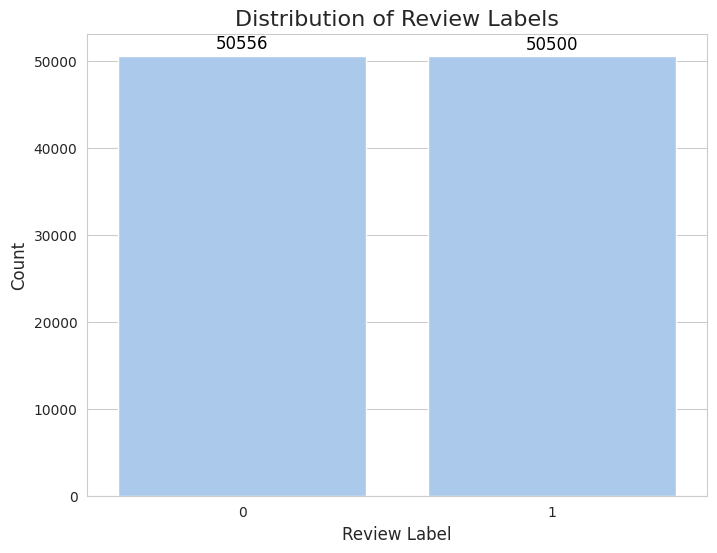

In [9]:
# 检查标签分布
print(df['Label'].value_counts())

# 画出标签分布的柱状图
plt.figure(figsize=(8, 6)) 
sns.set_style('whitegrid') 
sns.set_palette('pastel')  
ax = sns.countplot(x='Label', data=df)

# 在柱子上显示计数
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# 添加标题和标签
plt.xlabel('Review Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Review Labels', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

至此，得到了一个较为干净整洁的数据集。数据分布也很均匀。可以继续数据处理了。

## 数据处理

In [36]:
# 自定义模型
class CustomModel(nn.Module):
    def __init__(self, model_path):
        super(CustomModel, self).__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained(model_path)
        # 分类头
        self.fc = nn.Linear(768, 1)
        self.dropout1 = nn.Dropout(0.1)

    def forward(self, ids, mask):
        x = self.model(ids, mask)[0]
        x = self.dropout1(x)
        x = self.fc(x[:, 0, :])
        return x


class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        super(CustomDataset).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        row = self.df.iloc[index]

        inputs = self.tokenizer.encode_plus(
            row.text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        ids = torch.LongTensor(ids)
        mask = torch.LongTensor(mask)

        label = torch.FloatTensor([row.label])
        return ids, mask, label

    def __len__(self):
        return self.df.shape[0]


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


seed = 601
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [42]:
# 参数
DEBUG = False
data_path = 'goods_zh.txt'
model_name_or_path = 'bert-base-chinese'
lr = 5e-5
num_epochs = 1
batch_size = 64
max_len = 180
warm_up = 0.0
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [38]:
# 加载数据
df = pd.read_csv(data_path, header=None)
df.drop(1, axis=1, inplace=True)
df.columns = ['text', 'label']
df = df.dropna().reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.25, random_state=2024)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [39]:
# 测试，使用少量数据
if DEBUG:
    num_epochs = 2
    df_train = df_train.head(400)
    df_test = df_test.head(400)

In [43]:
# 线性schedule
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up * num_training_steps,
                                            num_training_steps=num_training_steps)
scaler = GradScaler()
loss_function = nn.BCEWithLogitsLoss() # 损失函数
best_score = 0.0
for epoch in range(num_epochs):
    losses = AverageMeter()
    # 训练阶段
    model.train()
    for i, (ids, mask, label) in enumerate(tqdm(train_loader)):
        ids = ids.to(device)
        mask = mask.to(device)
        label = label.to(device)
        label = label.squeeze().float()
        with autocast():
            output = model(ids, mask)
            output = output.squeeze(dim=-1)
            # if i == 0:
            #     print(f'label = {label.shape}, output = {output.shape}')
            loss = loss_function(output, label)
        scaler.scale(loss).backward()
        losses.update(loss.item(), output.size(0))
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

100%|██████████| 1184/1184 [03:08<00:00,  6.28it/s]


In [40]:
# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# dataset
train_dataset = CustomDataset(df_train, tokenizer, max_len)
valid_dataset = CustomDataset(df_test, tokenizer, max_len)

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          num_workers=1, drop_last=True, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size,
                          num_workers=1, drop_last=False, shuffle=False)


In [41]:
# 加载模型
model = CustomModel(model_name_or_path)
model.to(device) # 将模型切换到device（CPU或者GPU）上
num_training_steps = len(train_loader) * num_epochs
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01) # 优化器

In [45]:
# 验证阶段
valid_losses = AverageMeter()
model.eval()
preds_all = torch.LongTensor()
labels_all = torch.LongTensor()
for i, (ids, mask, label) in enumerate(tqdm(valid_loader)):
    labels_all = torch.cat((labels_all, label), dim=0)
    ids = ids.to(device)
    mask = mask.to(device)
    label = label.to(device)
    label = label.squeeze().float()
    with torch.no_grad():
        output = model(ids, mask)
        output = output.squeeze(dim=-1)
        valid_loss = loss_function(output, label)
    valid_losses.update(valid_loss.item(), output.size(0))
    preds_all = torch.cat((preds_all, torch.sigmoid(output).to('cpu')), dim=0)
# 计算准确率，阈值为0.5
preds_all_int = torch.where(preds_all > 0.5, 1.0, 0.0)
accuracy = accuracy_score(labels_all, preds_all_int)
print(f'epoch={epoch+1}/{num_epochs}, train_loss={round(losses.avg, 4)}, valid_loss={round(valid_losses.avg, 4)}, acc = {accuracy}')
    
# 保留最佳分数的模型权重
if accuracy > best_score:
    best_score = accuracy
    print(f'epoch={epoch+1}/{num_epochs}, best_score = {best_score}')
    print('Save Best Model...')
    torch.save(model.state_dict(), 'baseline_model.pt')


100%|██████████| 395/395 [00:50<00:00,  7.81it/s]


epoch=1/1, train_loss=0.1412, valid_loss=0.1302, acc = 0.9581634672471799
epoch=1/1, best_score = 0.9581634672471799
Save Best Model...
